<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 17.5MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [19]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 100
    batch_size = 16
    learning_rate = 2e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [20]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [21]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [22]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [43]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [23]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#6. Training and testing

In [24]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 50:
        return 0.25
    elif 50 <= epoch < 70:
        return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)
import torch.nn.functional as F

def boundary_loss(y_pred, y_true):
    # Ensure y_pred and y_true have the same number of channels
    assert y_pred.shape == y_true.shape, "Mismatch in shape"

    # Sobel filters
    sobel_kernel = torch.tensor([[[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]],
                                 [[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]]], dtype=torch.float32).to(y_pred.device)  # Shape: [2, 3, 3]
    sobel_kernel = sobel_kernel.unsqueeze(1)  # Shape: [2, 1, 3, 3]

    # Stack predictions and ground truths
    y_pred = torch.sigmoid(y_pred)  # Ensure y_pred is between 0 and 1
    y_true = y_true.float()

    # Compute gradients
    y_pred_grad = F.conv2d(y_pred, sobel_kernel, padding=1)
    y_true_grad = F.conv2d(y_true, sobel_kernel, padding=1)

    # Compute gradient magnitudes
    y_pred_grad_mag = torch.sqrt(y_pred_grad[:, 0] ** 2 + y_pred_grad[:, 1] ** 2 + 1e-7)
    y_true_grad_mag = torch.sqrt(y_true_grad[:, 0] ** 2 + y_true_grad[:, 1] ** 2 + 1e-7)

    # Compute L1 loss
    loss = F.l1_loss(y_pred_grad_mag, y_true_grad_mag)
    return loss




class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):#,weight_boundary =1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        #self.weight_boundary = weight_boundary

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        #boundary = boundary_loss(probs, targets)
        return self.weight_bce*bce_loss + self.weight_dice*dice_loss #+ self.weight_boundary*boundary
# BCE + DICE
criterion = CombinedLoss(weight_bce=0.2, weight_dice=1.0)#,weight_boundary=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [25]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 1/100, Training Loss: 0.7157


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 1/100, Validation Loss: 0.7506
Precision: 0.3661, Recall: 0.9583, Accuracy: 0.4555
IoU: 0.3575, F1 Score: 0.5298, Dice Coefficient: 0.5229
Pixel Error: 0.5445, Rand Error: 1.0394


Epoch 2/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 2/100, Training Loss: 0.6939


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 2/100, Validation Loss: 0.7388
Precision: 0.4170, Recall: 0.9164, Accuracy: 0.5631
IoU: 0.4015, F1 Score: 0.5732, Dice Coefficient: 0.5668
Pixel Error: 0.4369, Rand Error: 0.9810


Epoch 3/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 3/100, Training Loss: 0.6129


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 3/100, Validation Loss: 0.5175
Precision: 0.9131, Recall: 0.9067, Accuracy: 0.9425
IoU: 0.8316, F1 Score: 0.9099, Dice Coefficient: 0.9077
Pixel Error: 0.0575, Rand Error: 0.2229


Epoch 4/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 4/100, Training Loss: 0.5564


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 4/100, Validation Loss: 0.5716
Precision: 0.7857, Recall: 0.9558, Accuracy: 0.9024
IoU: 0.7592, F1 Score: 0.8625, Dice Coefficient: 0.8622
Pixel Error: 0.0976, Rand Error: 0.3532


Epoch 5/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 5/100, Training Loss: 0.5155


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 5/100, Validation Loss: 0.5390
Precision: 0.8586, Recall: 0.9659, Accuracy: 0.9382
IoU: 0.8305, F1 Score: 0.9091, Dice Coefficient: 0.9072
Pixel Error: 0.0618, Rand Error: 0.2362


Epoch 6/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 6/100, Training Loss: 0.4883


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 6/100, Validation Loss: 0.5240
Precision: 0.8011, Recall: 0.9867, Accuracy: 0.9173
IoU: 0.7875, F1 Score: 0.8843, Dice Coefficient: 0.8807
Pixel Error: 0.0827, Rand Error: 0.3071


Epoch 7/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 7/100, Training Loss: 0.4574


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 7/100, Validation Loss: 0.4940
Precision: 0.8998, Recall: 0.9478, Accuracy: 0.9495
IoU: 0.8572, F1 Score: 0.9232, Dice Coefficient: 0.9231
Pixel Error: 0.0505, Rand Error: 0.1949


Epoch 8/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 8/100, Training Loss: 0.4378


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 8/100, Validation Loss: 0.4837
Precision: 0.9117, Recall: 0.9227, Accuracy: 0.9466
IoU: 0.8435, F1 Score: 0.9172, Dice Coefficient: 0.9144
Pixel Error: 0.0534, Rand Error: 0.2081


Epoch 9/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 9/100, Training Loss: 0.4088


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 9/100, Validation Loss: 0.4547
Precision: 0.8763, Recall: 0.9623, Accuracy: 0.9444
IoU: 0.8465, F1 Score: 0.9173, Dice Coefficient: 0.9166
Pixel Error: 0.0556, Rand Error: 0.2132


Epoch 10/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 10/100, Training Loss: 0.3728


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 10/100, Validation Loss: 0.4100
Precision: 0.8980, Recall: 0.9808, Accuracy: 0.9582
IoU: 0.8800, F1 Score: 0.9376, Dice Coefficient: 0.9359
Pixel Error: 0.0418, Rand Error: 0.1643


Epoch 11/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 11/100, Training Loss: 0.3358


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 11/100, Validation Loss: 0.4493
Precision: 0.8921, Recall: 0.9226, Accuracy: 0.9395
IoU: 0.8250, F1 Score: 0.9071, Dice Coefficient: 0.9032
Pixel Error: 0.0605, Rand Error: 0.2342


Epoch 12/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 12/100, Training Loss: 0.3277


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 12/100, Validation Loss: 0.4252
Precision: 0.6900, Recall: 0.9086, Accuracy: 0.8400
IoU: 0.6455, F1 Score: 0.7843, Dice Coefficient: 0.7837
Pixel Error: 0.1600, Rand Error: 0.5350


Epoch 13/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 13/100, Training Loss: 0.3212


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 13/100, Validation Loss: 0.3622
Precision: 0.8261, Recall: 0.8260, Accuracy: 0.8886
IoU: 0.6922, F1 Score: 0.8260, Dice Coefficient: 0.8158
Pixel Error: 0.1114, Rand Error: 0.4087


Epoch 14/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 14/100, Training Loss: 0.3240


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 14/100, Validation Loss: 0.3479
Precision: 0.7775, Recall: 0.9221, Accuracy: 0.8906
IoU: 0.7200, F1 Score: 0.8436, Dice Coefficient: 0.8347
Pixel Error: 0.1094, Rand Error: 0.3984


Epoch 15/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 15/100, Training Loss: 0.2925


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 15/100, Validation Loss: 0.2939
Precision: 0.8541, Recall: 0.9657, Accuracy: 0.9362
IoU: 0.8244, F1 Score: 0.9065, Dice Coefficient: 0.9035
Pixel Error: 0.0638, Rand Error: 0.2439


Epoch 16/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 16/100, Training Loss: 0.2624


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 16/100, Validation Loss: 0.3040
Precision: 0.9126, Recall: 0.9213, Accuracy: 0.9465
IoU: 0.8496, F1 Score: 0.9169, Dice Coefficient: 0.9182
Pixel Error: 0.0535, Rand Error: 0.2053


Epoch 17/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 17/100, Training Loss: 0.2641


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 17/100, Validation Loss: 0.3537
Precision: 0.9180, Recall: 0.7832, Accuracy: 0.9082
IoU: 0.7304, F1 Score: 0.8453, Dice Coefficient: 0.8436
Pixel Error: 0.0918, Rand Error: 0.3437


Epoch 18/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 18/100, Training Loss: 0.2635


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 18/100, Validation Loss: 0.2438
Precision: 0.9331, Recall: 0.8994, Accuracy: 0.9472
IoU: 0.8433, F1 Score: 0.9160, Dice Coefficient: 0.9140
Pixel Error: 0.0528, Rand Error: 0.2051


Epoch 19/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 19/100, Training Loss: 0.2525


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 19/100, Validation Loss: 0.2730
Precision: 0.9173, Recall: 0.9121, Accuracy: 0.9455
IoU: 0.8398, F1 Score: 0.9147, Dice Coefficient: 0.9119
Pixel Error: 0.0545, Rand Error: 0.2115


Epoch 20/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 20/100, Training Loss: 0.2265


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 20/100, Validation Loss: 0.2192
Precision: 0.9047, Recall: 0.9541, Accuracy: 0.9531
IoU: 0.8663, F1 Score: 0.9288, Dice Coefficient: 0.9280
Pixel Error: 0.0469, Rand Error: 0.1824


Epoch 21/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 21/100, Training Loss: 0.2126


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 21/100, Validation Loss: 0.2426
Precision: 0.9552, Recall: 0.9089, Accuracy: 0.9572
IoU: 0.8706, F1 Score: 0.9315, Dice Coefficient: 0.9297
Pixel Error: 0.0428, Rand Error: 0.1690


Epoch 22/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 22/100, Training Loss: 0.1998


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 22/100, Validation Loss: 0.2161
Precision: 0.9292, Recall: 0.9449, Accuracy: 0.9593
IoU: 0.8800, F1 Score: 0.9370, Dice Coefficient: 0.9353
Pixel Error: 0.0407, Rand Error: 0.1603


Epoch 23/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 23/100, Training Loss: 0.1984


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 23/100, Validation Loss: 0.2202
Precision: 0.9414, Recall: 0.9349, Accuracy: 0.9605
IoU: 0.8818, F1 Score: 0.9382, Dice Coefficient: 0.9362
Pixel Error: 0.0395, Rand Error: 0.1560


Epoch 24/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 24/100, Training Loss: 0.1884


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 24/100, Validation Loss: 0.2107
Precision: 0.9142, Recall: 0.9629, Accuracy: 0.9592
IoU: 0.8816, F1 Score: 0.9379, Dice Coefficient: 0.9366
Pixel Error: 0.0408, Rand Error: 0.1601


Epoch 25/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 25/100, Training Loss: 0.1877


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 25/100, Validation Loss: 0.2102
Precision: 0.9207, Recall: 0.9603, Accuracy: 0.9608
IoU: 0.8864, F1 Score: 0.9401, Dice Coefficient: 0.9393
Pixel Error: 0.0392, Rand Error: 0.1535


Epoch 26/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 26/100, Training Loss: 0.1881


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 26/100, Validation Loss: 0.2143
Precision: 0.9593, Recall: 0.9145, Accuracy: 0.9602
IoU: 0.8810, F1 Score: 0.9364, Dice Coefficient: 0.9360
Pixel Error: 0.0398, Rand Error: 0.1564


Epoch 27/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 27/100, Training Loss: 0.1831


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 27/100, Validation Loss: 0.2013
Precision: 0.9288, Recall: 0.9561, Accuracy: 0.9625
IoU: 0.8872, F1 Score: 0.9422, Dice Coefficient: 0.9397
Pixel Error: 0.0375, Rand Error: 0.1489


Epoch 28/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 28/100, Training Loss: 0.1832


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 28/100, Validation Loss: 0.2123
Precision: 0.9041, Recall: 0.9609, Accuracy: 0.9549
IoU: 0.8691, F1 Score: 0.9316, Dice Coefficient: 0.9294
Pixel Error: 0.0451, Rand Error: 0.1752


Epoch 29/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 29/100, Training Loss: 0.1721


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 29/100, Validation Loss: 0.2008
Precision: 0.9386, Recall: 0.9342, Accuracy: 0.9594
IoU: 0.8795, F1 Score: 0.9364, Dice Coefficient: 0.9349
Pixel Error: 0.0406, Rand Error: 0.1597


Epoch 30/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 30/100, Training Loss: 0.1834


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 30/100, Validation Loss: 0.2030
Precision: 0.9259, Recall: 0.9377, Accuracy: 0.9560
IoU: 0.8682, F1 Score: 0.9317, Dice Coefficient: 0.9288
Pixel Error: 0.0440, Rand Error: 0.1728


Epoch 31/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 31/100, Training Loss: 0.1696


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 31/100, Validation Loss: 0.1939
Precision: 0.9424, Recall: 0.9381, Accuracy: 0.9618
IoU: 0.8858, F1 Score: 0.9403, Dice Coefficient: 0.9389
Pixel Error: 0.0382, Rand Error: 0.1508


Epoch 32/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 32/100, Training Loss: 0.1584


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 32/100, Validation Loss: 0.2004
Precision: 0.9203, Recall: 0.9503, Accuracy: 0.9577
IoU: 0.8779, F1 Score: 0.9350, Dice Coefficient: 0.9344
Pixel Error: 0.0423, Rand Error: 0.1649


Epoch 33/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 33/100, Training Loss: 0.1567


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Epoch 33/100, Validation Loss: 0.1937
Precision: 0.9305, Recall: 0.9538, Accuracy: 0.9624
IoU: 0.8882, F1 Score: 0.9420, Dice Coefficient: 0.9401
Pixel Error: 0.0376, Rand Error: 0.1488


Epoch 34/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 34/100, Training Loss: 0.1584


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 34/100, Validation Loss: 0.1857
Precision: 0.9406, Recall: 0.9522, Accuracy: 0.9655
IoU: 0.8973, F1 Score: 0.9464, Dice Coefficient: 0.9453
Pixel Error: 0.0345, Rand Error: 0.1368


Epoch 35/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 35/100, Training Loss: 0.1515


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 35/100, Validation Loss: 0.1820
Precision: 0.9441, Recall: 0.9526, Accuracy: 0.9668
IoU: 0.9020, F1 Score: 0.9483, Dice Coefficient: 0.9480
Pixel Error: 0.0332, Rand Error: 0.1313


Epoch 36/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 36/100, Training Loss: 0.1439


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 36/100, Validation Loss: 0.1774
Precision: 0.9469, Recall: 0.9489, Accuracy: 0.9666
IoU: 0.9016, F1 Score: 0.9479, Dice Coefficient: 0.9478
Pixel Error: 0.0334, Rand Error: 0.1317


Epoch 37/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 37/100, Training Loss: 0.1551


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 37/100, Validation Loss: 0.1768
Precision: 0.9462, Recall: 0.9518, Accuracy: 0.9673
IoU: 0.9017, F1 Score: 0.9490, Dice Coefficient: 0.9478
Pixel Error: 0.0327, Rand Error: 0.1301


Epoch 38/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 38/100, Training Loss: 0.1531


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 38/100, Validation Loss: 0.1733
Precision: 0.9370, Recall: 0.9591, Accuracy: 0.9663
IoU: 0.8998, F1 Score: 0.9479, Dice Coefficient: 0.9469
Pixel Error: 0.0337, Rand Error: 0.1335


Epoch 39/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 39/100, Training Loss: 0.1433


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 39/100, Validation Loss: 0.1735
Precision: 0.9517, Recall: 0.9407, Accuracy: 0.9657
IoU: 0.8978, F1 Score: 0.9462, Dice Coefficient: 0.9456
Pixel Error: 0.0343, Rand Error: 0.1355


Epoch 40/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 40/100, Training Loss: 0.1486


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 40/100, Validation Loss: 0.1721
Precision: 0.9467, Recall: 0.9518, Accuracy: 0.9674
IoU: 0.9026, F1 Score: 0.9492, Dice Coefficient: 0.9483
Pixel Error: 0.0326, Rand Error: 0.1293


Epoch 41/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 41/100, Training Loss: 0.1522


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 41/100, Validation Loss: 0.1701
Precision: 0.9413, Recall: 0.9569, Accuracy: 0.9671
IoU: 0.9019, F1 Score: 0.9490, Dice Coefficient: 0.9480
Pixel Error: 0.0329, Rand Error: 0.1308


Epoch 42/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 42/100, Training Loss: 0.1380


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 42/100, Validation Loss: 0.1699
Precision: 0.9520, Recall: 0.9467, Accuracy: 0.9676
IoU: 0.9025, F1 Score: 0.9493, Dice Coefficient: 0.9483
Pixel Error: 0.0324, Rand Error: 0.1288


Epoch 43/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 43/100, Training Loss: 0.1464


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 43/100, Validation Loss: 0.1660
Precision: 0.9448, Recall: 0.9519, Accuracy: 0.9668
IoU: 0.9018, F1 Score: 0.9483, Dice Coefficient: 0.9479
Pixel Error: 0.0332, Rand Error: 0.1311


Epoch 44/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 44/100, Training Loss: 0.1408


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 44/100, Validation Loss: 0.1612
Precision: 0.9373, Recall: 0.9614, Accuracy: 0.9671
IoU: 0.9035, F1 Score: 0.9492, Dice Coefficient: 0.9489
Pixel Error: 0.0329, Rand Error: 0.1301


Epoch 45/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 45/100, Training Loss: 0.1376


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 45/100, Validation Loss: 0.1676
Precision: 0.9462, Recall: 0.9517, Accuracy: 0.9672
IoU: 0.9033, F1 Score: 0.9489, Dice Coefficient: 0.9487
Pixel Error: 0.0328, Rand Error: 0.1295


Epoch 46/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 46/100, Training Loss: 0.1384


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 46/100, Validation Loss: 0.1638
Precision: 0.9310, Recall: 0.9697, Accuracy: 0.9673
IoU: 0.9016, F1 Score: 0.9500, Dice Coefficient: 0.9479
Pixel Error: 0.0327, Rand Error: 0.1303


Epoch 47/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 47/100, Training Loss: 0.1379


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 47/100, Validation Loss: 0.1583
Precision: 0.9498, Recall: 0.9568, Accuracy: 0.9700
IoU: 0.9102, F1 Score: 0.9533, Dice Coefficient: 0.9527
Pixel Error: 0.0300, Rand Error: 0.1191


Epoch 48/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 48/100, Training Loss: 0.1331


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 48/100, Validation Loss: 0.1699
Precision: 0.9377, Recall: 0.9473, Accuracy: 0.9630
IoU: 0.8903, F1 Score: 0.9425, Dice Coefficient: 0.9413
Pixel Error: 0.0370, Rand Error: 0.1457


Epoch 49/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 49/100, Training Loss: 0.1340


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 49/100, Validation Loss: 0.1598
Precision: 0.9445, Recall: 0.9489, Accuracy: 0.9658
IoU: 0.8985, F1 Score: 0.9467, Dice Coefficient: 0.9460
Pixel Error: 0.0342, Rand Error: 0.1350


Epoch 50/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 50/100, Training Loss: 0.1286


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 50/100, Validation Loss: 0.1522
Precision: 0.9448, Recall: 0.9603, Accuracy: 0.9693
IoU: 0.9087, F1 Score: 0.9525, Dice Coefficient: 0.9518
Pixel Error: 0.0307, Rand Error: 0.1216


Epoch 51/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 51/100, Training Loss: 0.1295


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 51/100, Validation Loss: 0.1549
Precision: 0.9519, Recall: 0.9525, Accuracy: 0.9694
IoU: 0.9084, F1 Score: 0.9522, Dice Coefficient: 0.9516
Pixel Error: 0.0306, Rand Error: 0.1214


Epoch 52/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 52/100, Training Loss: 0.1260


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 52/100, Validation Loss: 0.1528
Precision: 0.9543, Recall: 0.9516, Accuracy: 0.9699
IoU: 0.9096, F1 Score: 0.9529, Dice Coefficient: 0.9522
Pixel Error: 0.0301, Rand Error: 0.1195


Epoch 53/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 53/100, Training Loss: 0.1247


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 53/100, Validation Loss: 0.1575
Precision: 0.9547, Recall: 0.9469, Accuracy: 0.9686
IoU: 0.9067, F1 Score: 0.9507, Dice Coefficient: 0.9506
Pixel Error: 0.0314, Rand Error: 0.1241


Epoch 54/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 54/100, Training Loss: 0.1204


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 54/100, Validation Loss: 0.1515
Precision: 0.9471, Recall: 0.9579, Accuracy: 0.9694
IoU: 0.9088, F1 Score: 0.9525, Dice Coefficient: 0.9518
Pixel Error: 0.0306, Rand Error: 0.1214


Epoch 55/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 55/100, Training Loss: 0.1192


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 55/100, Validation Loss: 0.1498
Precision: 0.9535, Recall: 0.9497, Accuracy: 0.9691
IoU: 0.9054, F1 Score: 0.9516, Dice Coefficient: 0.9498
Pixel Error: 0.0309, Rand Error: 0.1240


Epoch 56/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 56/100, Training Loss: 0.1280


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 56/100, Validation Loss: 0.1517
Precision: 0.9558, Recall: 0.9493, Accuracy: 0.9697
IoU: 0.9073, F1 Score: 0.9525, Dice Coefficient: 0.9508
Pixel Error: 0.0303, Rand Error: 0.1212


Epoch 57/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 57/100, Training Loss: 0.1168


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 57/100, Validation Loss: 0.1479
Precision: 0.9495, Recall: 0.9573, Accuracy: 0.9700
IoU: 0.9107, F1 Score: 0.9534, Dice Coefficient: 0.9529
Pixel Error: 0.0300, Rand Error: 0.1187


Epoch 58/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 58/100, Training Loss: 0.1201


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 58/100, Validation Loss: 0.1468
Precision: 0.9554, Recall: 0.9564, Accuracy: 0.9718
IoU: 0.9141, F1 Score: 0.9559, Dice Coefficient: 0.9548
Pixel Error: 0.0282, Rand Error: 0.1128


Epoch 59/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 59/100, Training Loss: 0.1285


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 59/100, Validation Loss: 0.1500
Precision: 0.9487, Recall: 0.9602, Accuracy: 0.9706
IoU: 0.9105, F1 Score: 0.9544, Dice Coefficient: 0.9527
Pixel Error: 0.0294, Rand Error: 0.1175


Epoch 60/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 60/100, Training Loss: 0.1198


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 60/100, Validation Loss: 0.1518
Precision: 0.9556, Recall: 0.9470, Accuracy: 0.9690
IoU: 0.9054, F1 Score: 0.9513, Dice Coefficient: 0.9498
Pixel Error: 0.0310, Rand Error: 0.1240


Epoch 61/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 61/100, Training Loss: 0.1228


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 61/100, Validation Loss: 0.1480
Precision: 0.9570, Recall: 0.9514, Accuracy: 0.9708
IoU: 0.9110, F1 Score: 0.9542, Dice Coefficient: 0.9531
Pixel Error: 0.0292, Rand Error: 0.1170


Epoch 62/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 62/100, Training Loss: 0.1128


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 62/100, Validation Loss: 0.1425
Precision: 0.9497, Recall: 0.9608, Accuracy: 0.9712
IoU: 0.9115, F1 Score: 0.9552, Dice Coefficient: 0.9533
Pixel Error: 0.0288, Rand Error: 0.1161


Epoch 63/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 63/100, Training Loss: 0.1134


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 63/100, Validation Loss: 0.1402
Precision: 0.9509, Recall: 0.9592, Accuracy: 0.9711
IoU: 0.9113, F1 Score: 0.9550, Dice Coefficient: 0.9532
Pixel Error: 0.0289, Rand Error: 0.1163


Epoch 64/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 64/100, Training Loss: 0.1110


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 64/100, Validation Loss: 0.1413
Precision: 0.9474, Recall: 0.9606, Accuracy: 0.9703
IoU: 0.9109, F1 Score: 0.9540, Dice Coefficient: 0.9530
Pixel Error: 0.0297, Rand Error: 0.1183


Epoch 65/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 65/100, Training Loss: 0.1100


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 65/100, Validation Loss: 0.1430
Precision: 0.9504, Recall: 0.9563, Accuracy: 0.9700
IoU: 0.9102, F1 Score: 0.9533, Dice Coefficient: 0.9526
Pixel Error: 0.0300, Rand Error: 0.1192


Epoch 66/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 66/100, Training Loss: 0.1146


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 66/100, Validation Loss: 0.1434
Precision: 0.9529, Recall: 0.9545, Accuracy: 0.9703
IoU: 0.9108, F1 Score: 0.9537, Dice Coefficient: 0.9530
Pixel Error: 0.0297, Rand Error: 0.1184


Epoch 67/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 67/100, Training Loss: 0.1087


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 67/100, Validation Loss: 0.1403
Precision: 0.9541, Recall: 0.9547, Accuracy: 0.9708
IoU: 0.9117, F1 Score: 0.9544, Dice Coefficient: 0.9535
Pixel Error: 0.0292, Rand Error: 0.1167


Epoch 68/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 68/100, Training Loss: 0.1151


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 68/100, Validation Loss: 0.1429
Precision: 0.9531, Recall: 0.9564, Accuracy: 0.9710
IoU: 0.9129, F1 Score: 0.9548, Dice Coefficient: 0.9542
Pixel Error: 0.0290, Rand Error: 0.1154


Epoch 69/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 69/100, Training Loss: 0.1071


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 69/100, Validation Loss: 0.1359
Precision: 0.9492, Recall: 0.9574, Accuracy: 0.9700
IoU: 0.9098, F1 Score: 0.9533, Dice Coefficient: 0.9524
Pixel Error: 0.0300, Rand Error: 0.1194


Epoch 70/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 70/100, Training Loss: 0.1121


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 70/100, Validation Loss: 0.1398
Precision: 0.9508, Recall: 0.9552, Accuracy: 0.9698
IoU: 0.9091, F1 Score: 0.9530, Dice Coefficient: 0.9520
Pixel Error: 0.0302, Rand Error: 0.1202


Epoch 71/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 71/100, Training Loss: 0.1064


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 71/100, Validation Loss: 0.1404
Precision: 0.9516, Recall: 0.9510, Accuracy: 0.9688
IoU: 0.9069, F1 Score: 0.9513, Dice Coefficient: 0.9508
Pixel Error: 0.0312, Rand Error: 0.1235


Epoch 72/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 72/100, Training Loss: 0.1082


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 72/100, Validation Loss: 0.1406
Precision: 0.9497, Recall: 0.9542, Accuracy: 0.9691
IoU: 0.9080, F1 Score: 0.9519, Dice Coefficient: 0.9513
Pixel Error: 0.0309, Rand Error: 0.1223


Epoch 73/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 73/100, Training Loss: 0.1112


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 73/100, Validation Loss: 0.1397
Precision: 0.9514, Recall: 0.9536, Accuracy: 0.9695
IoU: 0.9099, F1 Score: 0.9525, Dice Coefficient: 0.9524
Pixel Error: 0.0305, Rand Error: 0.1204


Epoch 74/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 74/100, Training Loss: 0.1030


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 74/100, Validation Loss: 0.1383
Precision: 0.9551, Recall: 0.9502, Accuracy: 0.9698
IoU: 0.9097, F1 Score: 0.9526, Dice Coefficient: 0.9522
Pixel Error: 0.0302, Rand Error: 0.1198


Epoch 75/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 75/100, Training Loss: 0.1138


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 75/100, Validation Loss: 0.1379
Precision: 0.9517, Recall: 0.9559, Accuracy: 0.9704
IoU: 0.9113, F1 Score: 0.9538, Dice Coefficient: 0.9532
Pixel Error: 0.0296, Rand Error: 0.1177


Epoch 76/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 76/100, Training Loss: 0.1040


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 76/100, Validation Loss: 0.1387
Precision: 0.9498, Recall: 0.9550, Accuracy: 0.9694
IoU: 0.9090, F1 Score: 0.9524, Dice Coefficient: 0.9519
Pixel Error: 0.0306, Rand Error: 0.1211


Epoch 77/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 77/100, Training Loss: 0.1045


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 77/100, Validation Loss: 0.1485
Precision: 0.9545, Recall: 0.9363, Accuracy: 0.9653
IoU: 0.8968, F1 Score: 0.9453, Dice Coefficient: 0.9449
Pixel Error: 0.0347, Rand Error: 0.1367


Epoch 78/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 78/100, Training Loss: 0.1037


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 78/100, Validation Loss: 0.1400
Precision: 0.9531, Recall: 0.9447, Accuracy: 0.9674
IoU: 0.9032, F1 Score: 0.9489, Dice Coefficient: 0.9486
Pixel Error: 0.0326, Rand Error: 0.1287


Epoch 79/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 79/100, Training Loss: 0.1039


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 79/100, Validation Loss: 0.1367
Precision: 0.9535, Recall: 0.9473, Accuracy: 0.9683
IoU: 0.9060, F1 Score: 0.9504, Dice Coefficient: 0.9502
Pixel Error: 0.0317, Rand Error: 0.1252


Epoch 80/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 80/100, Training Loss: 0.1041


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 80/100, Validation Loss: 0.1387
Precision: 0.9516, Recall: 0.9488, Accuracy: 0.9682
IoU: 0.9063, F1 Score: 0.9502, Dice Coefficient: 0.9504
Pixel Error: 0.0318, Rand Error: 0.1255


Epoch 81/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 81/100, Training Loss: 0.1057


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 81/100, Validation Loss: 0.1387
Precision: 0.9497, Recall: 0.9517, Accuracy: 0.9684
IoU: 0.9062, F1 Score: 0.9507, Dice Coefficient: 0.9505
Pixel Error: 0.0316, Rand Error: 0.1251


Epoch 82/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 82/100, Training Loss: 0.1032


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 82/100, Validation Loss: 0.1399
Precision: 0.9536, Recall: 0.9469, Accuracy: 0.9683
IoU: 0.9053, F1 Score: 0.9503, Dice Coefficient: 0.9499
Pixel Error: 0.0317, Rand Error: 0.1257


Epoch 83/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 83/100, Training Loss: 0.1020


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 83/100, Validation Loss: 0.1385
Precision: 0.9562, Recall: 0.9433, Accuracy: 0.9680
IoU: 0.9047, F1 Score: 0.9497, Dice Coefficient: 0.9495
Pixel Error: 0.0320, Rand Error: 0.1266


Epoch 84/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 84/100, Training Loss: 0.0987


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 84/100, Validation Loss: 0.1338
Precision: 0.9491, Recall: 0.9540, Accuracy: 0.9689
IoU: 0.9081, F1 Score: 0.9516, Dice Coefficient: 0.9515
Pixel Error: 0.0311, Rand Error: 0.1229


Epoch 85/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 85/100, Training Loss: 0.1048


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 85/100, Validation Loss: 0.1324
Precision: 0.9506, Recall: 0.9524, Accuracy: 0.9689
IoU: 0.9079, F1 Score: 0.9515, Dice Coefficient: 0.9514
Pixel Error: 0.0311, Rand Error: 0.1229


Epoch 86/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 86/100, Training Loss: 0.0974


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 86/100, Validation Loss: 0.1372
Precision: 0.9514, Recall: 0.9488, Accuracy: 0.9681
IoU: 0.9041, F1 Score: 0.9501, Dice Coefficient: 0.9492
Pixel Error: 0.0319, Rand Error: 0.1269


Epoch 87/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 87/100, Training Loss: 0.1011


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 87/100, Validation Loss: 0.1383
Precision: 0.9482, Recall: 0.9511, Accuracy: 0.9677
IoU: 0.9049, F1 Score: 0.9497, Dice Coefficient: 0.9497
Pixel Error: 0.0323, Rand Error: 0.1273


Epoch 88/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 88/100, Training Loss: 0.1055


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 88/100, Validation Loss: 0.1405
Precision: 0.9544, Recall: 0.9458, Accuracy: 0.9682
IoU: 0.9055, F1 Score: 0.9501, Dice Coefficient: 0.9500
Pixel Error: 0.0318, Rand Error: 0.1258


Epoch 89/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 89/100, Training Loss: 0.1017


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 89/100, Validation Loss: 0.1417
Precision: 0.9544, Recall: 0.9450, Accuracy: 0.9679
IoU: 0.9048, F1 Score: 0.9496, Dice Coefficient: 0.9496
Pixel Error: 0.0321, Rand Error: 0.1268


Epoch 90/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 90/100, Training Loss: 0.1025


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 90/100, Validation Loss: 0.1362
Precision: 0.9520, Recall: 0.9523, Accuracy: 0.9694
IoU: 0.9085, F1 Score: 0.9521, Dice Coefficient: 0.9517
Pixel Error: 0.0306, Rand Error: 0.1215


Epoch 91/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 91/100, Training Loss: 0.1025


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 91/100, Validation Loss: 0.1373
Precision: 0.9490, Recall: 0.9533, Accuracy: 0.9686
IoU: 0.9055, F1 Score: 0.9511, Dice Coefficient: 0.9500
Pixel Error: 0.0314, Rand Error: 0.1249


Epoch 92/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 92/100, Training Loss: 0.0982


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 92/100, Validation Loss: 0.1386
Precision: 0.9455, Recall: 0.9550, Accuracy: 0.9680
IoU: 0.9053, F1 Score: 0.9502, Dice Coefficient: 0.9499
Pixel Error: 0.0320, Rand Error: 0.1266


Epoch 93/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 93/100, Training Loss: 0.1041


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 93/100, Validation Loss: 0.1377
Precision: 0.9485, Recall: 0.9543, Accuracy: 0.9688
IoU: 0.9073, F1 Score: 0.9514, Dice Coefficient: 0.9511
Pixel Error: 0.0312, Rand Error: 0.1238


Epoch 94/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 94/100, Training Loss: 0.0969


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 94/100, Validation Loss: 0.1374
Precision: 0.9508, Recall: 0.9491, Accuracy: 0.9680
IoU: 0.9060, F1 Score: 0.9499, Dice Coefficient: 0.9503
Pixel Error: 0.0320, Rand Error: 0.1262


Epoch 95/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 95/100, Training Loss: 0.0980


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 95/100, Validation Loss: 0.1383
Precision: 0.9534, Recall: 0.9507, Accuracy: 0.9694
IoU: 0.9090, F1 Score: 0.9521, Dice Coefficient: 0.9520
Pixel Error: 0.0306, Rand Error: 0.1214


Epoch 96/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 96/100, Training Loss: 0.1045


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 96/100, Validation Loss: 0.1320
Precision: 0.9560, Recall: 0.9485, Accuracy: 0.9695
IoU: 0.9098, F1 Score: 0.9522, Dice Coefficient: 0.9524
Pixel Error: 0.0305, Rand Error: 0.1207


Epoch 97/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 97/100, Training Loss: 0.0936


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 97/100, Validation Loss: 0.1290
Precision: 0.9581, Recall: 0.9473, Accuracy: 0.9699
IoU: 0.9103, F1 Score: 0.9527, Dice Coefficient: 0.9526
Pixel Error: 0.0301, Rand Error: 0.1195


Epoch 98/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 98/100, Training Loss: 0.0985


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 98/100, Validation Loss: 0.1313
Precision: 0.9591, Recall: 0.9439, Accuracy: 0.9691
IoU: 0.9085, F1 Score: 0.9514, Dice Coefficient: 0.9516
Pixel Error: 0.0309, Rand Error: 0.1221


Epoch 99/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 99/100, Training Loss: 0.0980


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 99/100, Validation Loss: 0.1289
Precision: 0.9573, Recall: 0.9476, Accuracy: 0.9697
IoU: 0.9096, F1 Score: 0.9524, Dice Coefficient: 0.9522
Pixel Error: 0.0303, Rand Error: 0.1204


Epoch 100/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 100/100, Training Loss: 0.0919


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

Epoch 100/100, Validation Loss: 0.1300
Precision: 0.9548, Recall: 0.9473, Accuracy: 0.9688
IoU: 0.9073, F1 Score: 0.9511, Dice Coefficient: 0.9509
Pixel Error: 0.0312, Rand Error: 0.1237


##6.2 Testing



In [26]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

Test Loss: 0.1480
Average Precision: 0.9415
Average Recall: 0.9397
Average Accuracy: 0.9650
Average IoU: 0.8883
Average F1 Score: 0.9400
Average Dice Coefficient: 0.9400
Average Pixel Error: 0.0350
Average Rand Error: 0.0350


In [27]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [28]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-28-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

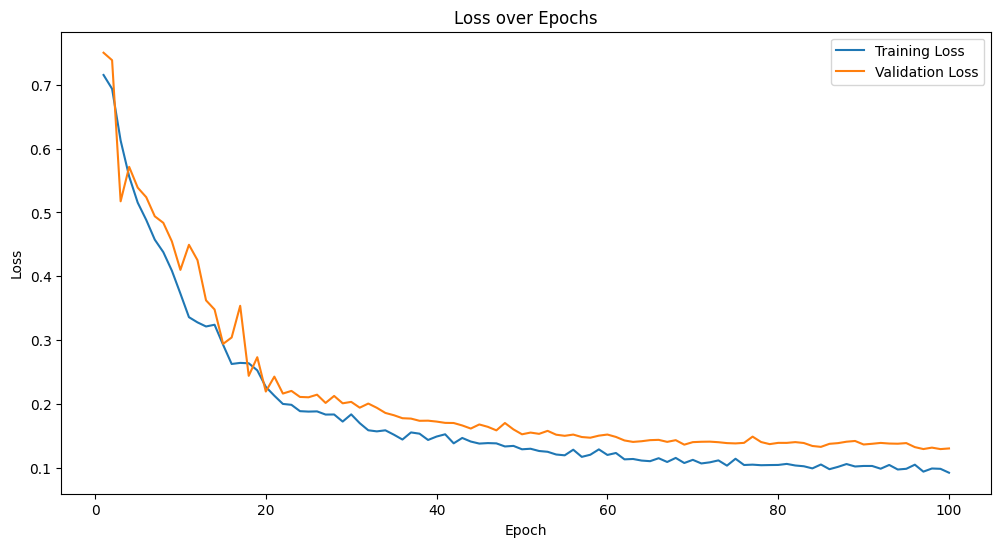

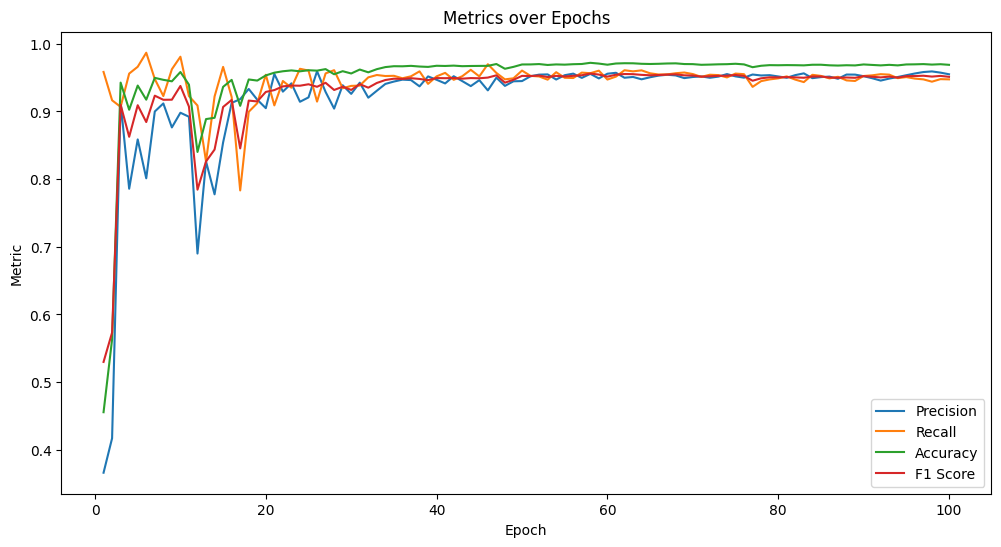

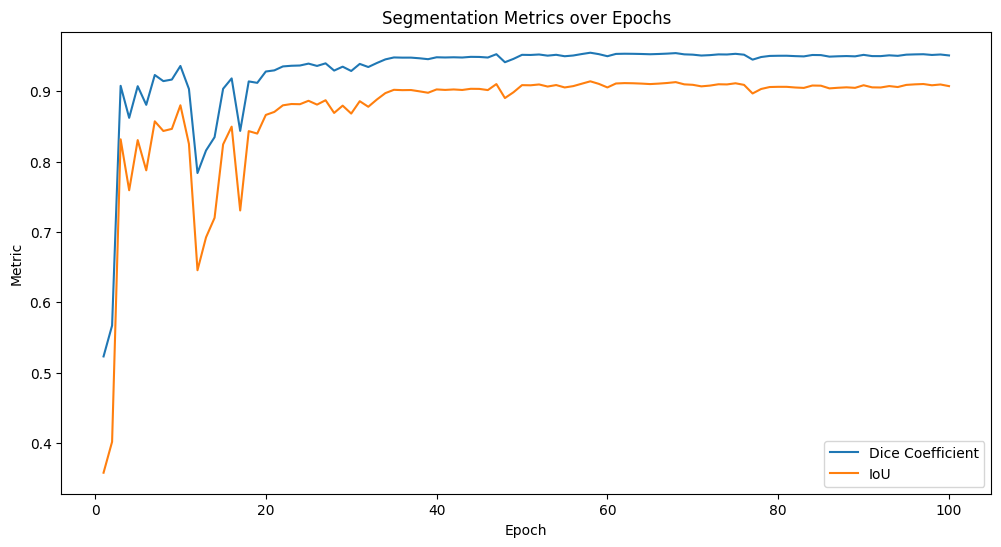

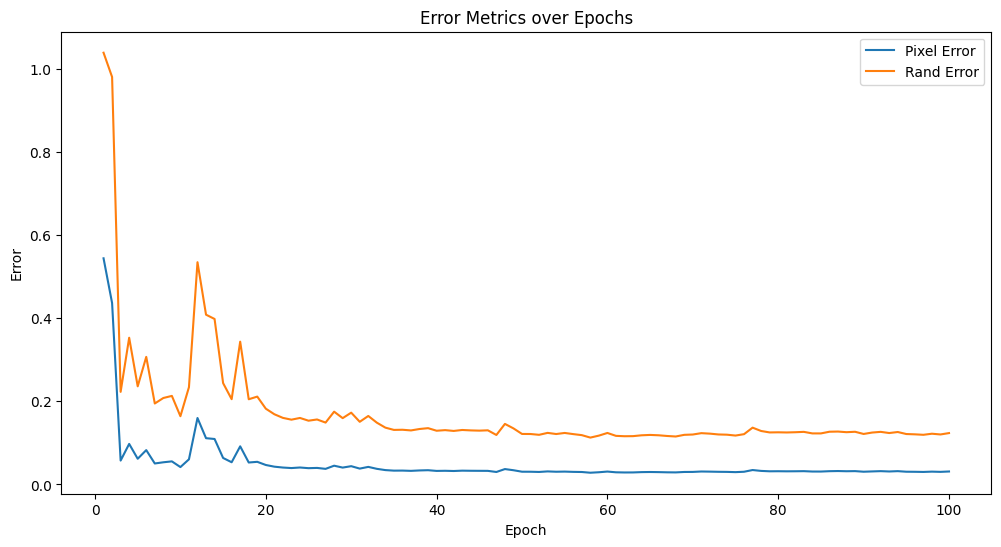

In [29]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



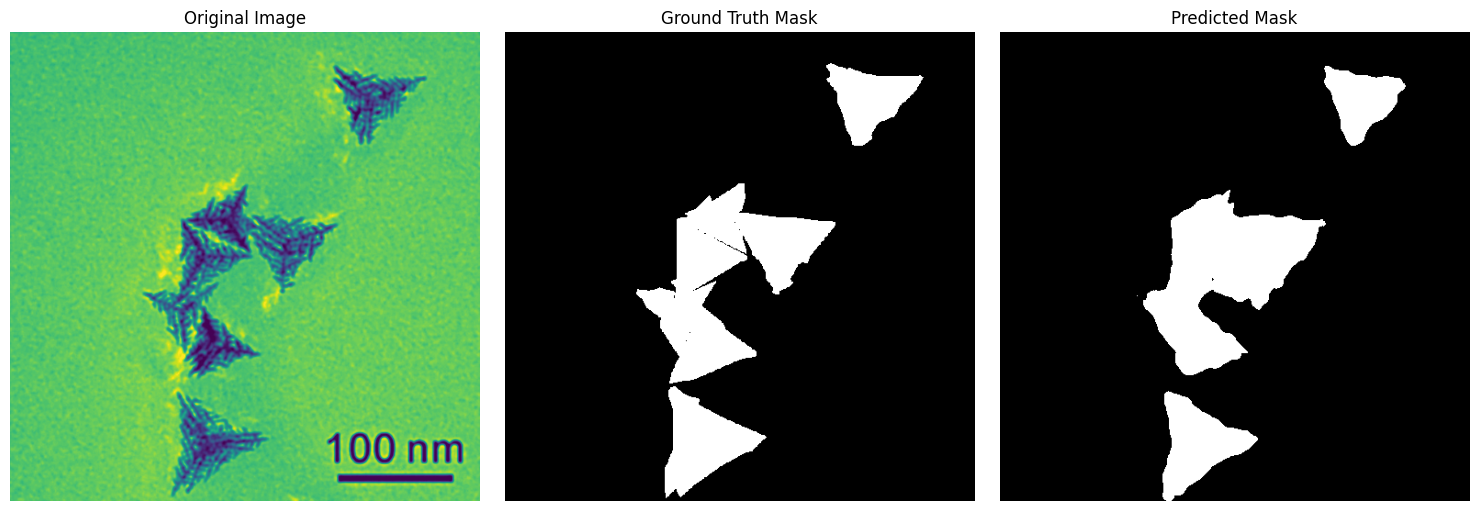

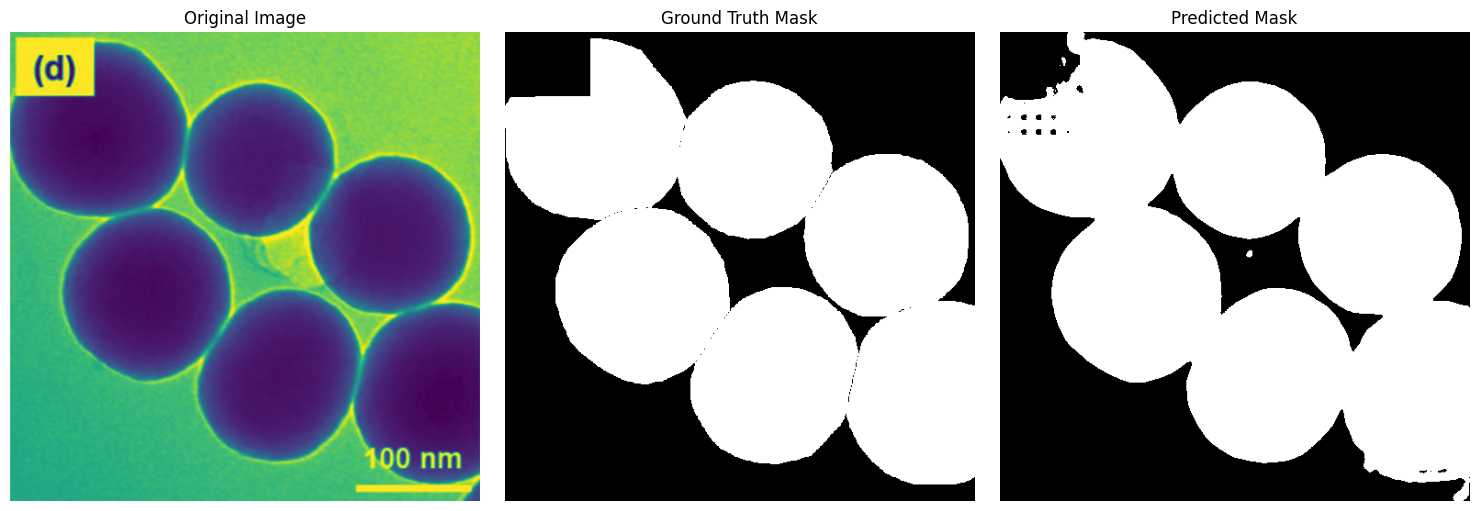

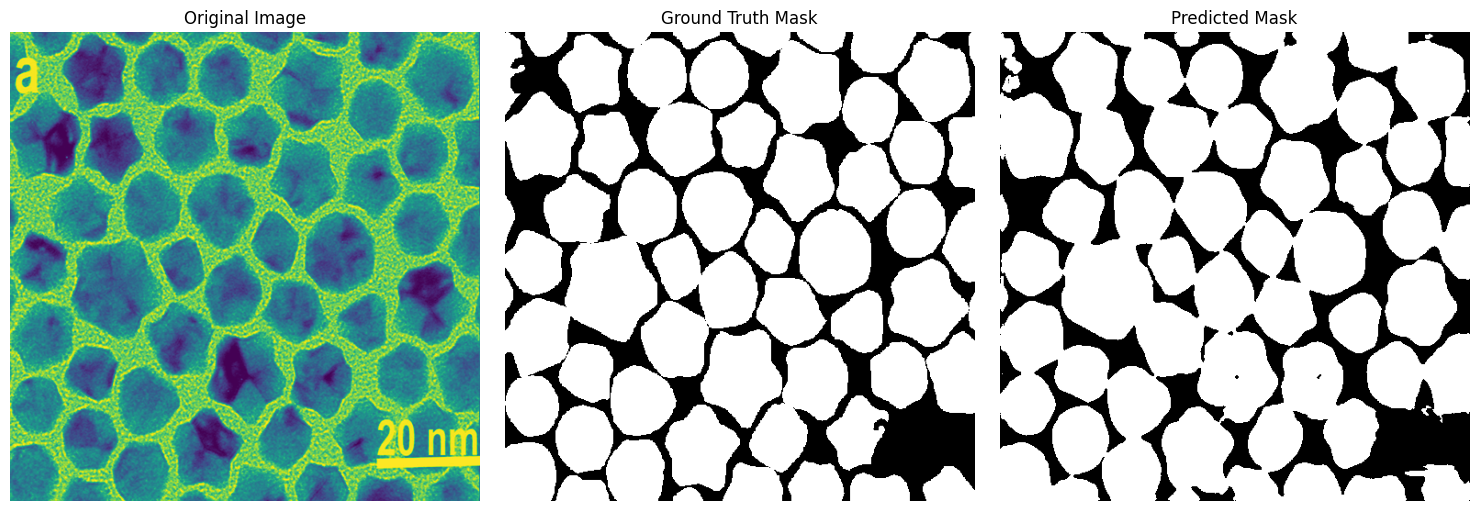

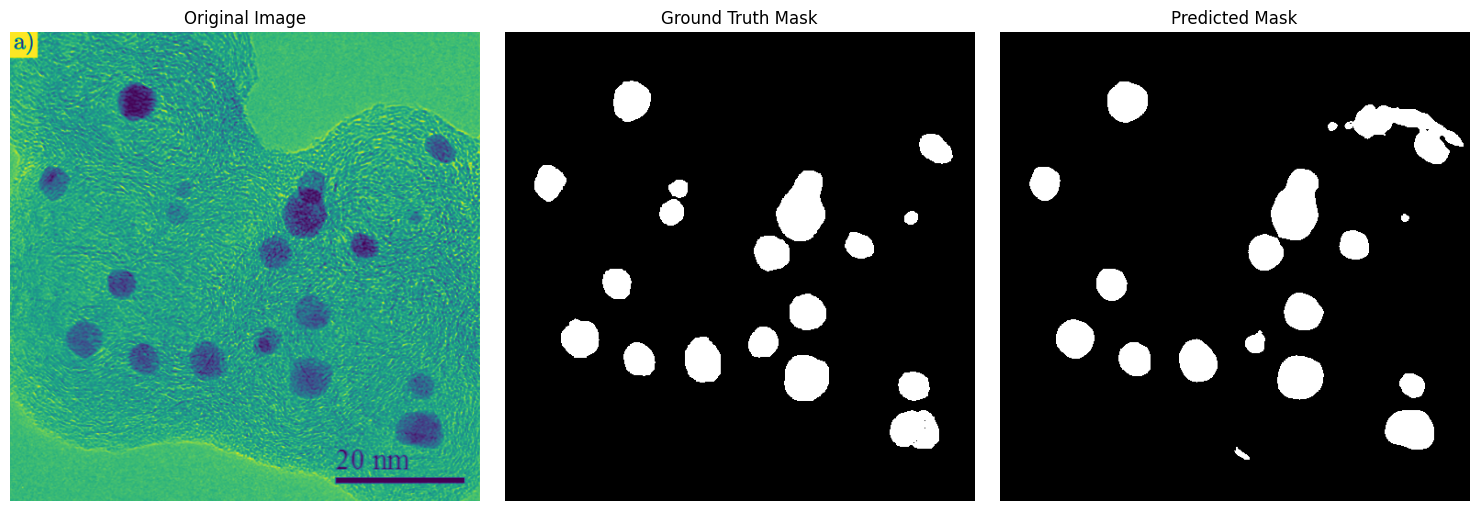

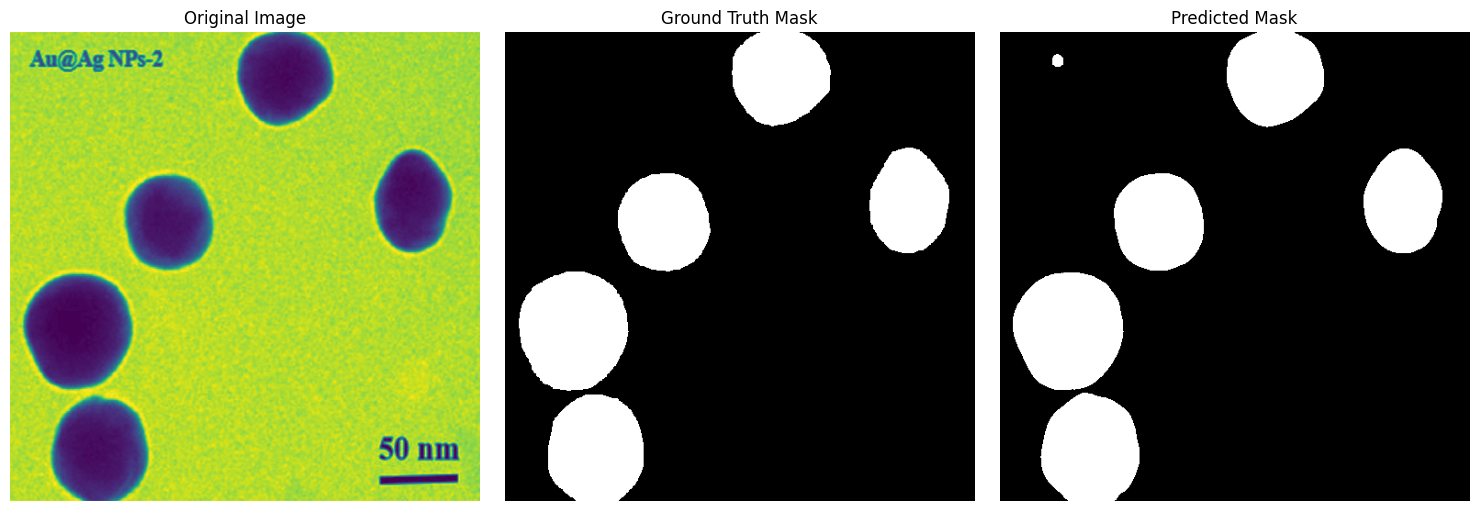

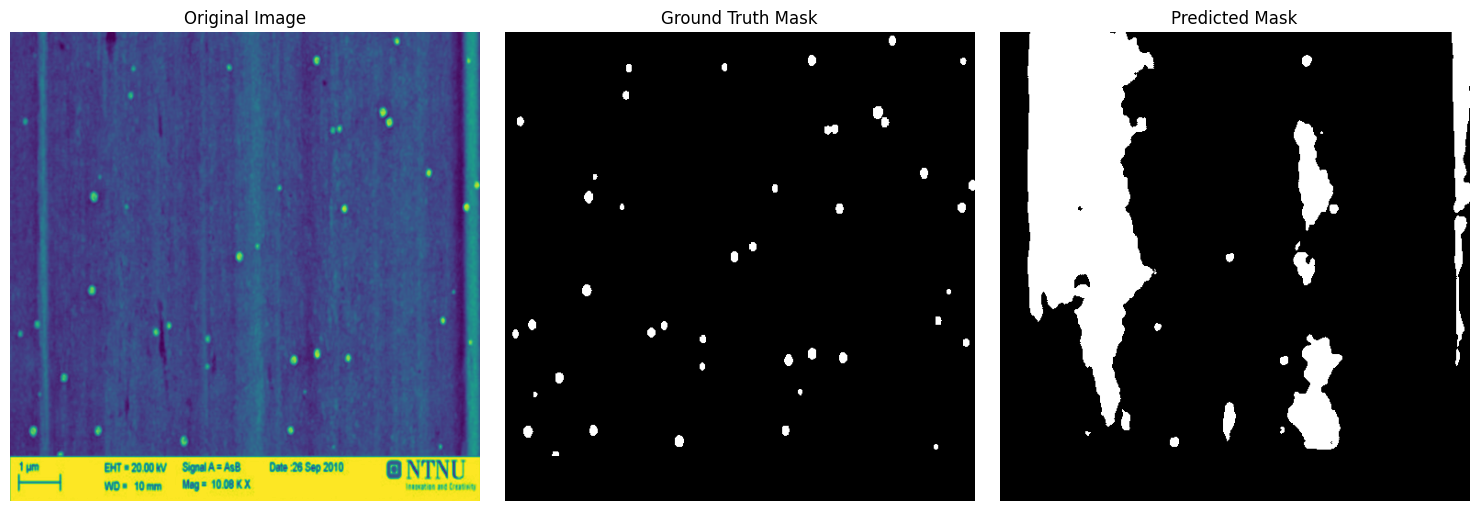

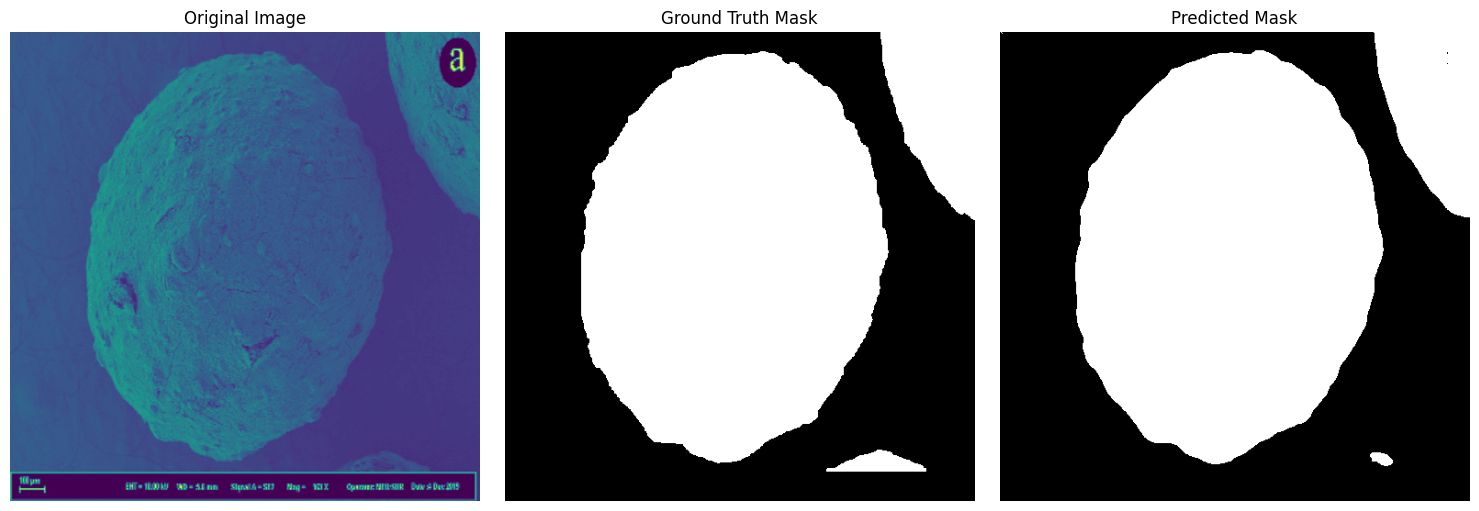

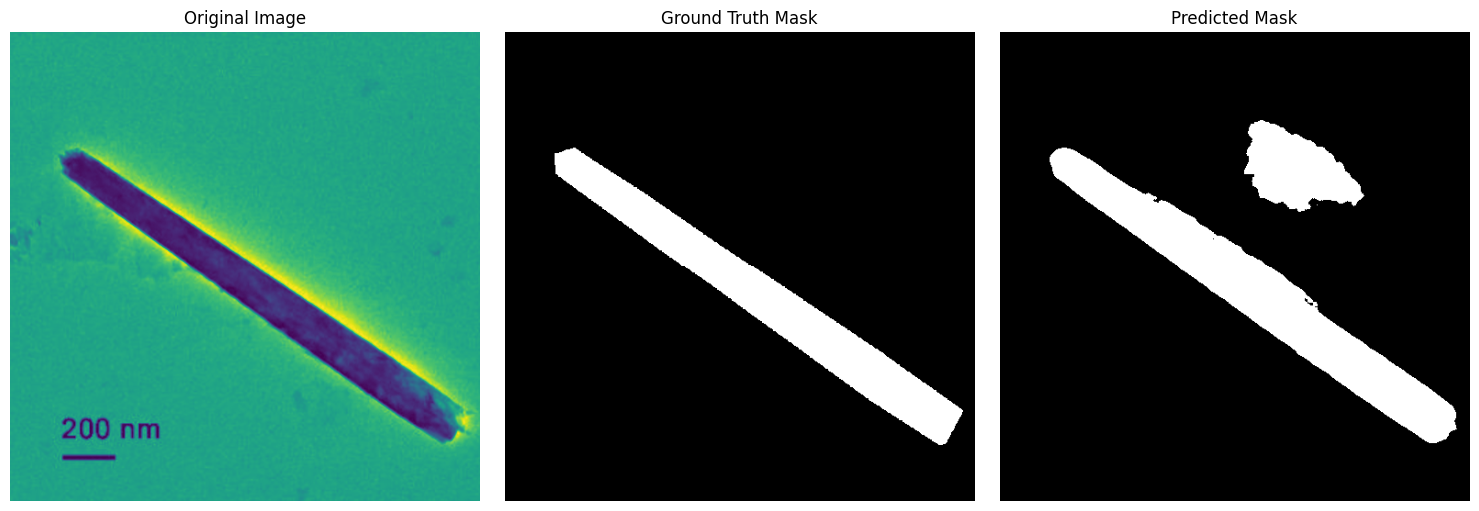

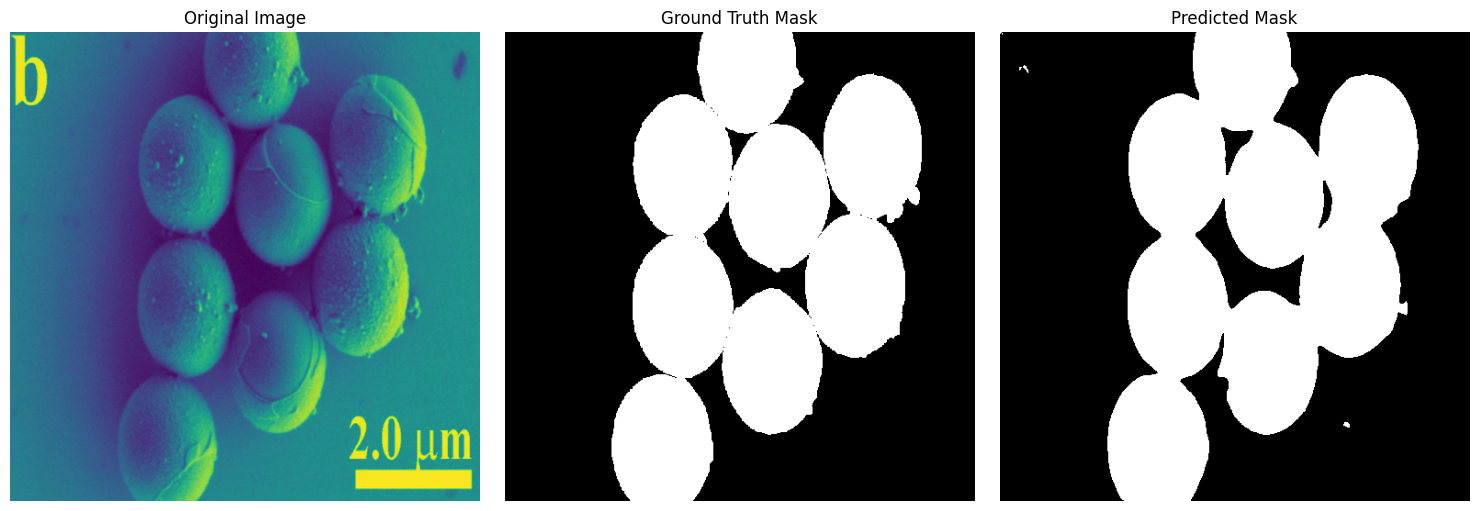

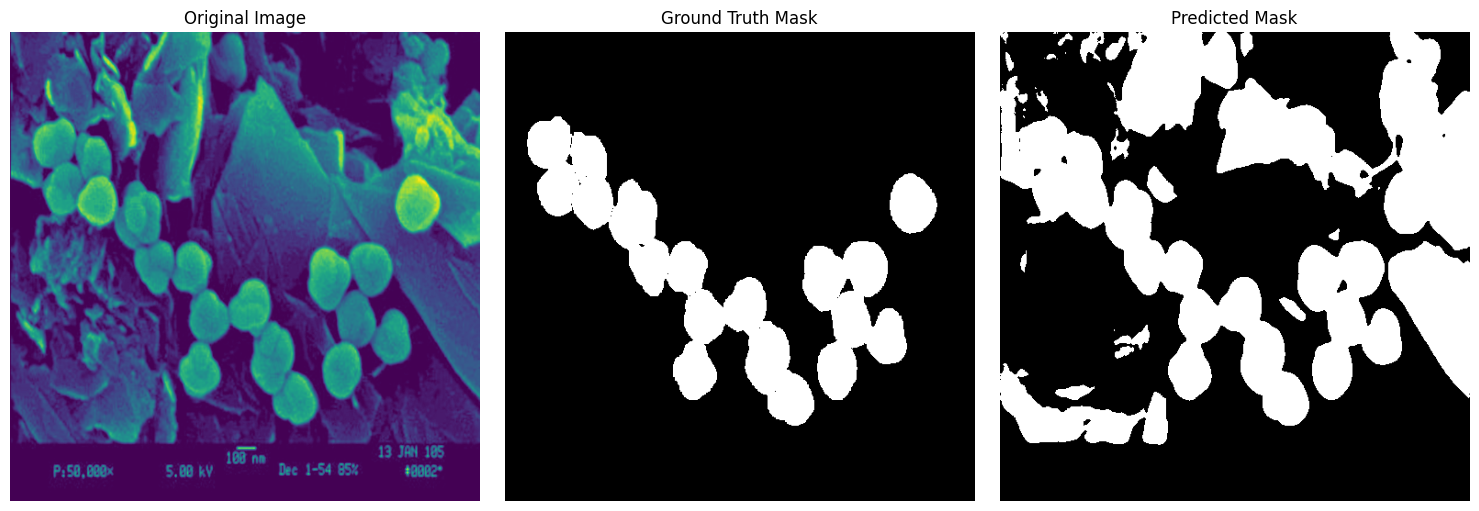

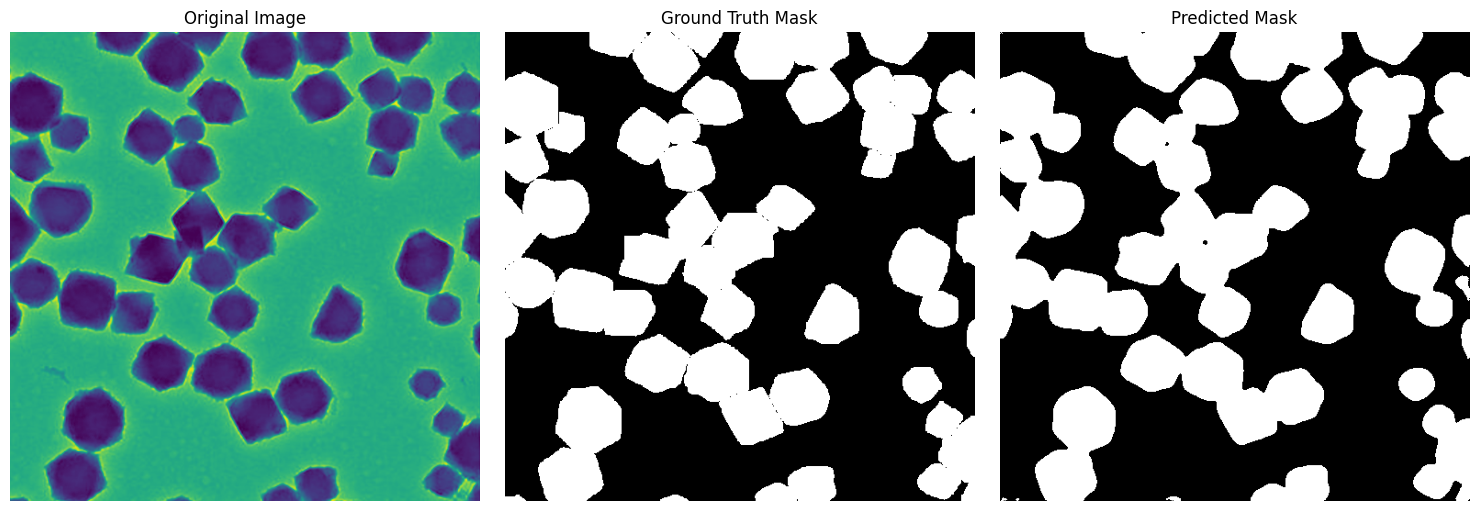

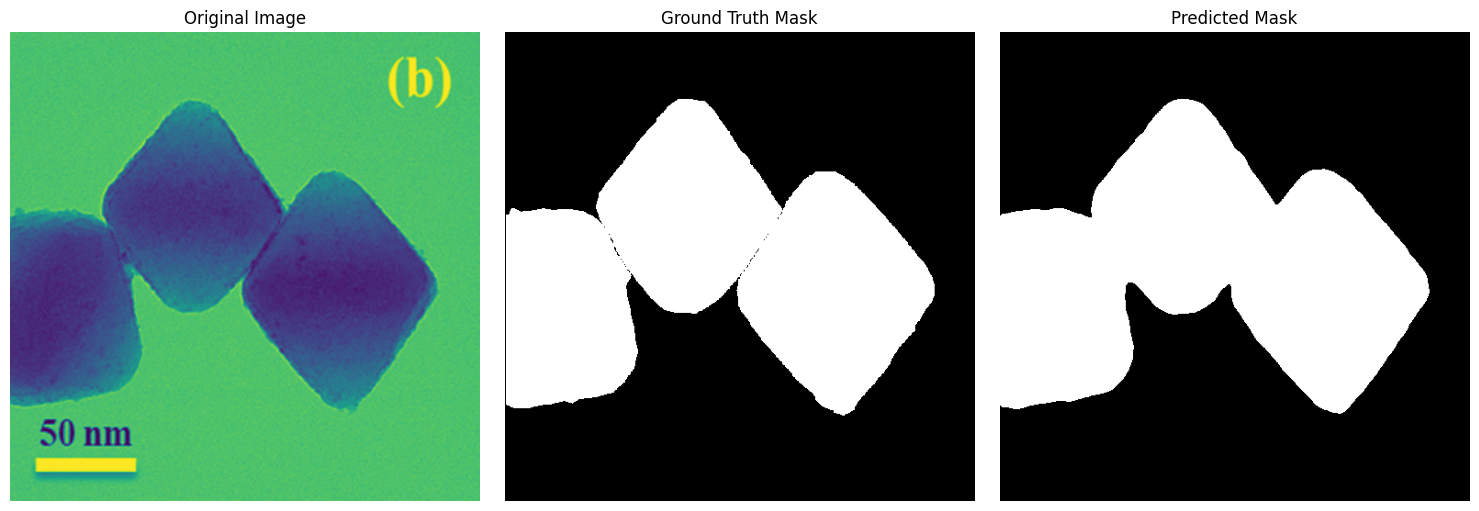

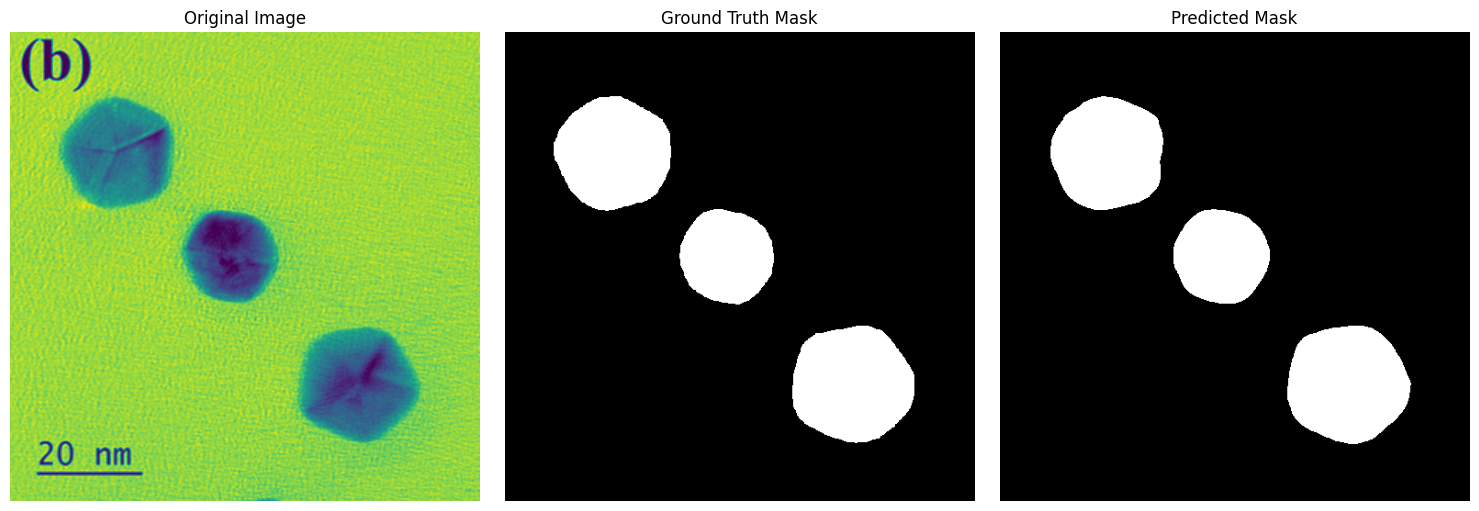

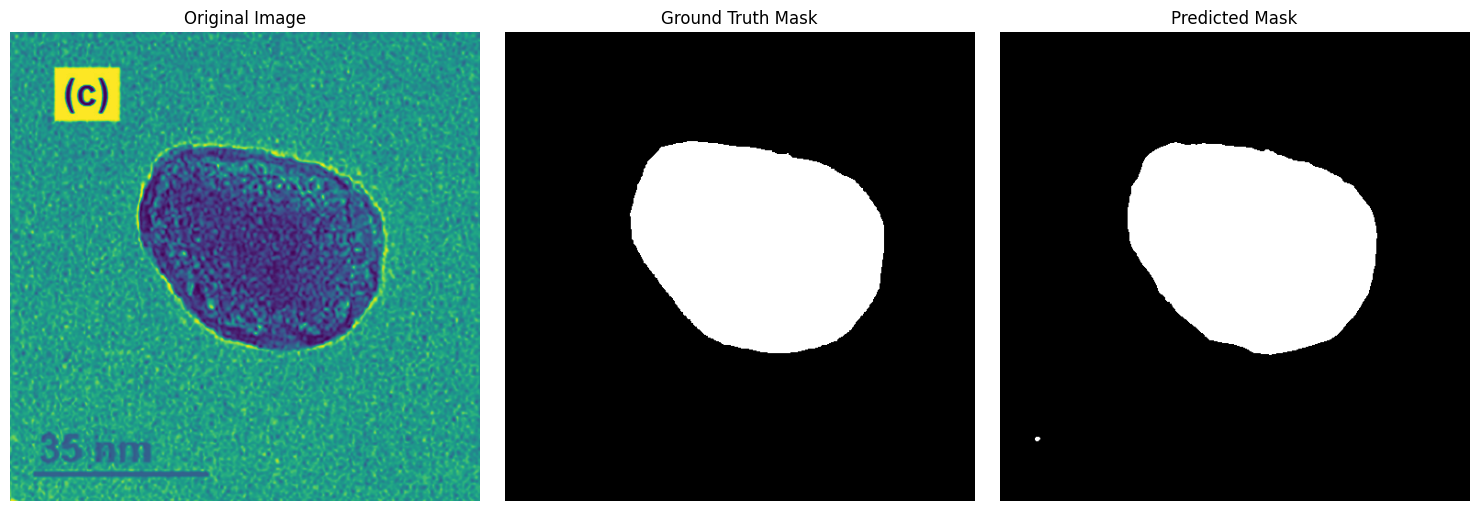

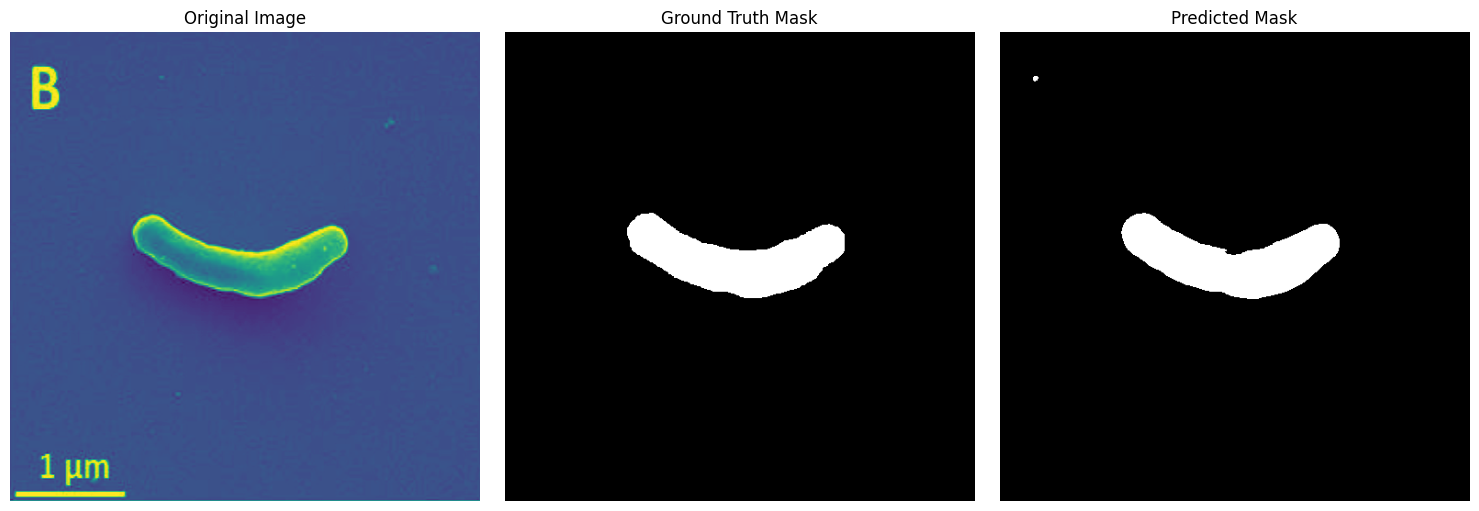

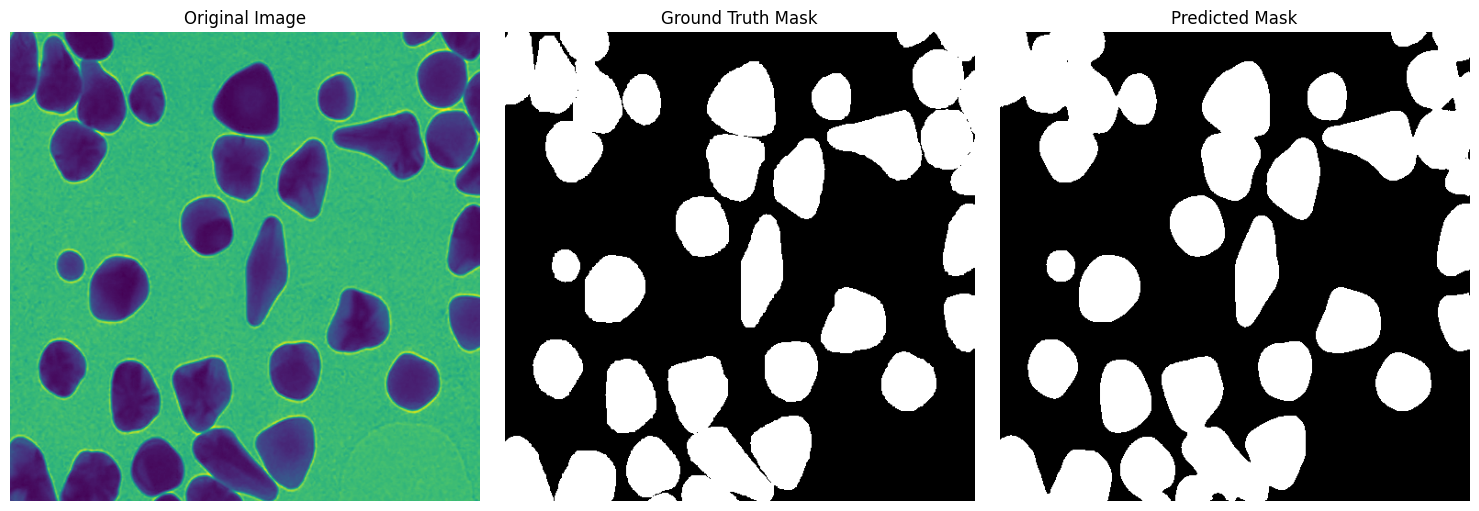

In [30]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [31]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy       iou  \
0       1    0.715672  0.750574   0.366138  0.958274  0.455546  0.357531   
1       2    0.693933  0.738840   0.417042  0.916410  0.563149  0.401515   
2       3    0.612871  0.517549   0.913118  0.906662  0.942502  0.831615   
3       4    0.556446  0.571574   0.785737  0.955836  0.902419  0.759217   
4       5    0.515472  0.538993   0.858600  0.965911  0.938162  0.830506   
..    ...         ...       ...        ...       ...       ...       ...   
95     96    0.104480  0.132046   0.955995  0.948458  0.969523  0.909781   
96     97    0.093588  0.128994   0.958136  0.947304  0.969880  0.910257   
97     98    0.098510  0.131251   0.959060  0.943897  0.969141  0.908468   
98     99    0.098001  0.128941   0.957284  0.947637  0.969700  0.909601   
99    100    0.091885  0.129954   0.954848  0.947320  0.968795  0.907265   

          f1  dice_coeff  rand_error  pixel_error  
0   0.529835    0.522901    1.03940